In [1]:
from dataclasses import dataclass
from typing import Any, Callable
from __future__ import annotations
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

$$
\renewcommand{\paren}[1]{\left(#1\right)}
\renewcommand{\brac}[1]{\left[#1\right]}
\renewcommand{\P}[1]{\Pr\paren{#1}}
\renewcommand{\E}[1]{\mathbb{E}\brac{#1}}
\renewcommand{\var}[1]{\mathrm{Var}\brac{#1}}
\renewcommand{\ate}[]{\mathrm{ATE}}
\renewcommand{\att}[]{\mathrm{ATT}}
\renewcommand{\atu}[]{\mathrm{ATU}}
$$

## はじめに

こちらの@yohei_econさんのツイートを見て知ったのですが、OLS推定量が一体何を推定しているのかを因果推論の文脈で改めて考え直す論文が発表されていました。
https://twitter.com/yohei_econ/status/1414601655161548802?s=20

この記事では、Słoczyński(2020) "Interpreting ols estimands when treatment effects are heterogeneous: Smaller groups get larger weights."の主張を紹介し、実際にその主張が成り立っているのかをシミュレーションで確認します。

## 線形回帰モデルは何を推定しているのか

因果推論の文脈で処置効果（treatment effect）を推定する様々な手法が提案されていますが、実務家の中ではまだまだOLSで処置効果を分析している例が多く見られます。
処置効果をOLSで推定する典型的な例として、以下のような線形回帰モデル
$$
\begin{align}
    Y = \alpha + \tau D + X'\beta + U
\end{align}
$$
を考えます。
ここで、それぞれ

- $Y$：目的変数
- $D$：処置を受けたら1、受けていなければ0をとるダミー変数
- $X$：コントロール変数
- $U$：誤差項
- $\tau$：OLSで推定される処置効果
- $(\alpha, \beta)$：その他の回帰パラメータ

を表しています。

平たく言うと、「処置変数$D$とコントロール変数$X$をぜんぶ回帰モデルに突っ込んで、処置変数$D$の回帰係数$\tau$を推定したら、これが処置の平均的な効果でしょ」というのがこのモデルの発想です。
実際、処置効果が一定なら、OLSで推定した処置効果は（いくつかの仮定のもとで）真の処置効果と一致します。
問題は処置効果に異質性がある場合、つまり、処置を受けるユニットによって処置効果が異なる場合です。

処置効果に異質性がある場合、代表的な推定したい効果（estimand）として

- ATE：サンプル全体に対する平均的な処置効果
- ATT：処置群に対する平均的な処置効果
- ATU：対照群に対する平均的な処置効果

が挙げられますが、（処置効果の異質性を明示的に考慮せずに）OLSで処置効果$\tau$を推定した場合、一体どのグループに対する平均的な処置効果が推定されるのでしょうか？
この疑問に対して、OLSで推定された処置効果は（いくつかの仮定のもとで）以下のようなATTとATUの加重平均になるというのが論文の主張です。
$$
\begin{align}
\tau = w\tau_{\att} + (1-w)\tau_{\atu}
\end{align}
$$
ここで、重み$w$は
$$
\begin{align}
w &= \frac{\paren{1 - \rho}\var{e(X) \mid D=0}}{\rho\var{e(X) \mid D=1} + \paren{1 - \rho}\var{e(X) \mid D=0}}
\end{align}
$$
で定義され、$\rho = \P{D=1}$はサンプルに占める処置群の割合を、さらに$e(X)$は傾向スコアを表します。

話を簡単にするために、いったん傾向スコアの条件付き分散は一定（$\var{e(X) \mid D=0} = \var{e(X) \mid D=1} = \sigma^2$）としましょう。
すると、重み$w$は
$$
\begin{align}
w 
&= \frac{\paren{1 - \rho}\sigma^2}{\rho\sigma^2 + \paren{1 - \rho}\sigma^2}\\
&= 1 - \rho
\end{align}
$$
と簡略化できます。
よって、OLSで推定した処置効果は、
$$
\begin{align}
\tau = \paren{1-\rho}\tau_{\att} + \rho\tau_{\atu}
\end{align}
$$
と書けます。
つまり、サンプルに占める処置群の割合が大きくなるほどATUに近くなり、対照群の割合が大きくなるほどATTに近くなることがわかります。

OLSで推定した処置効果はATTとATUの加重平均なのでATEになっているかというと、そうでもありません。
ATEはサンプル全体の処置効果なので、ATTは処置群の割合で、ATUは対照群の割合で重みを付けて加重平均します。
$$
\tau_{\ate} = \rho \tau_{\att} + \paren{1-\rho}\tau_{\atu}
$$
つまり、OLSによって推定される処置効果は、ATEとは逆の割合でATTとATUの重みを付けた加重平均になっていると言えます。

## シミュレーション

それでは、処置効果に異質性がある場合のOLS推定量の振る舞いをシミュレーションで確認してみましょう。
以下の設定でシミュレーションデータを生成します。

$$
\begin{align}
    Y &= \tau(X) D + X + U,\\
    X &\sim \mathrm{Uniform}(0, 1),\\
    D &\sim \mathrm{Bernoulli}(e(X)),\\
    U &\sim \mathcal{N}(0, 0.1^2),\\
    \tau(X) &= X,\\
    e(X) &= \P{D = 1 \mid X} = \theta X\\
    \theta &\in (0, 1]
\end{align}
$$

ここで、

- 説明変数$X$は区間$[0, 1]$の一様分布から生成します。$X$は目的変数$Y$、$D=1$になる確率$e(X)$、処置効果の強さ$\tau(X)$の3つに影響を与えます
- 処置変数$D$は成功確率$e(X)$のベルヌーイ分布から生成します
- ノイズ$U$は平均0、分散0.01の正規分布から生成します
- 処置効果$\tau(X) = X$としています。つまり、処置効果には異質性があり、$X$が大きいユニットほど処置効果$\tau(X)$が大きくなります
- 処置変数$D$が1になる確率は$e(X) = \P{D = 1 \mid X} = \theta X$としています。つまり、$X$が大きいユニットほど処置を受ける確率が高くなります。なお、$X$は目的変数$Y$にも直接影響を与えるので、いわゆる交絡が発生しています
- $\theta$は0より大きく1以下の値をとるパラメータで、$\theta$が大きいほど処置群の割合が大きくなります

それでは、この設定でシミュレーションデータを生成し、OLSによる処置効果$\tau$を推定します。
合わせて、ATE、ATT、ATU、処置群の割合$\rho$、重み$w$などの各種理論値を計算し、OLS推定量と各種指標の関係を確認します。

In [3]:
# 関数を用意
def generate_simulation_data(
    n_samples: int, theta: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """シミュレーションデータの生成"""

    X = np.random.uniform(0, 1, n_samples)
    U = np.random.normal(0, 0.1, n_samples)

    e_X = theta * X
    D = np.random.binomial(1, e_X, n_samples)
    tau = X

    Y = tau * D + X + U

    return (X, Y, D, tau, e_X)


def estimate_tau(X: np.ndarray, D: np.ndarray, Y: np.ndarray) -> float:
    """OLSによる処置効果tauの推定"""

    Z = np.column_stack([X, D])

    return (np.linalg.inv(Z.T @ Z) @ (Z.T @ Y))[1]


def calc_treatment_effect(
    D: np.ndarray, tau: np.ndarray, e_X: np.ndarray
) -> tuple[float, float, float, float, float]:
    """理論上の各種処置効果を計算"""
    
    is_treat = D.astype(bool)

    att = tau[is_treat].mean()
    atu = tau[~is_treat].mean()
    ate = tau.mean()

    rho = D.mean()
    var_e_0 = tau[~is_treat].var()
    var_e_1 = tau[is_treat].var()
    w = (1 - rho) * var_e_0 / ((1 - rho) * var_e_0 + rho * var_e_1)

    return (att, atu, ate, rho, w)


# thetaの値を変動させたときにOLSを推定量tauがどのように変化するかをシミュレーション
thetas = np.arange(0.1, 1.1, 0.1)

# thetaの数 x (rho, w, ols, att, atu, ate)
results = np.zeros((thetas.shape[0], 6))

for t, theta in enumerate(thetas):
    # データを生成
    X, Y, D, tau, e_X = generate_simulation_data(n_samples=1000000, theta=theta)
    
    # 処置効果tauをOLSで推定
    tau_hat = estimate_tau(X, D, Y)
    
    # 処置効果の理論値を計算
    att, atu, ate, rho, w = calc_treatment_effect(D, tau, e_X)
    
    # 各種指標を保存
    results[t, :] = np.array([rho, w, tau_hat, att, atu, ate])

シミュレーション結果をデータフレームにまとめて確認します。

In [4]:
# 結果をデータフレームとしてまとめる
df_simulation = pd.DataFrame({"theta": thetas})
df_simulation[["rho", "w", "OLS", "ATT", "ATU", "ATE"]] = results

df_simulation

,theta,rho,w,OLS,ATT,ATU,ATE
0,0.1,0.050065,0.966249,0.660375,0.666286,0.491588,0.500334
1,0.2,0.100121,0.930907,0.653444,0.666652,0.481084,0.499663
2,0.3,0.149789,0.894566,0.646695,0.667451,0.470407,0.499922
3,0.4,0.199862,0.854556,0.636324,0.666510,0.458109,0.499760
4,0.5,0.250508,0.811860,0.624971,0.666640,0.444622,0.500239
5,0.6,0.300161,0.766195,0.610725,0.666141,0.428775,0.500023
6,0.7,0.349942,0.716122,0.594028,0.666906,0.411010,0.500559
7,0.8,0.399781,0.657424,0.572534,0.667729,0.388805,0.500313
8,0.9,0.449101,0.587984,0.542068,0.666661,0.363010,0.499380
9,1.0,0.499524,0.499813,0.499930,0.666453,0.332371,0.499253


データフレームだけだと分かりづらいので結果を可視化しておきます。

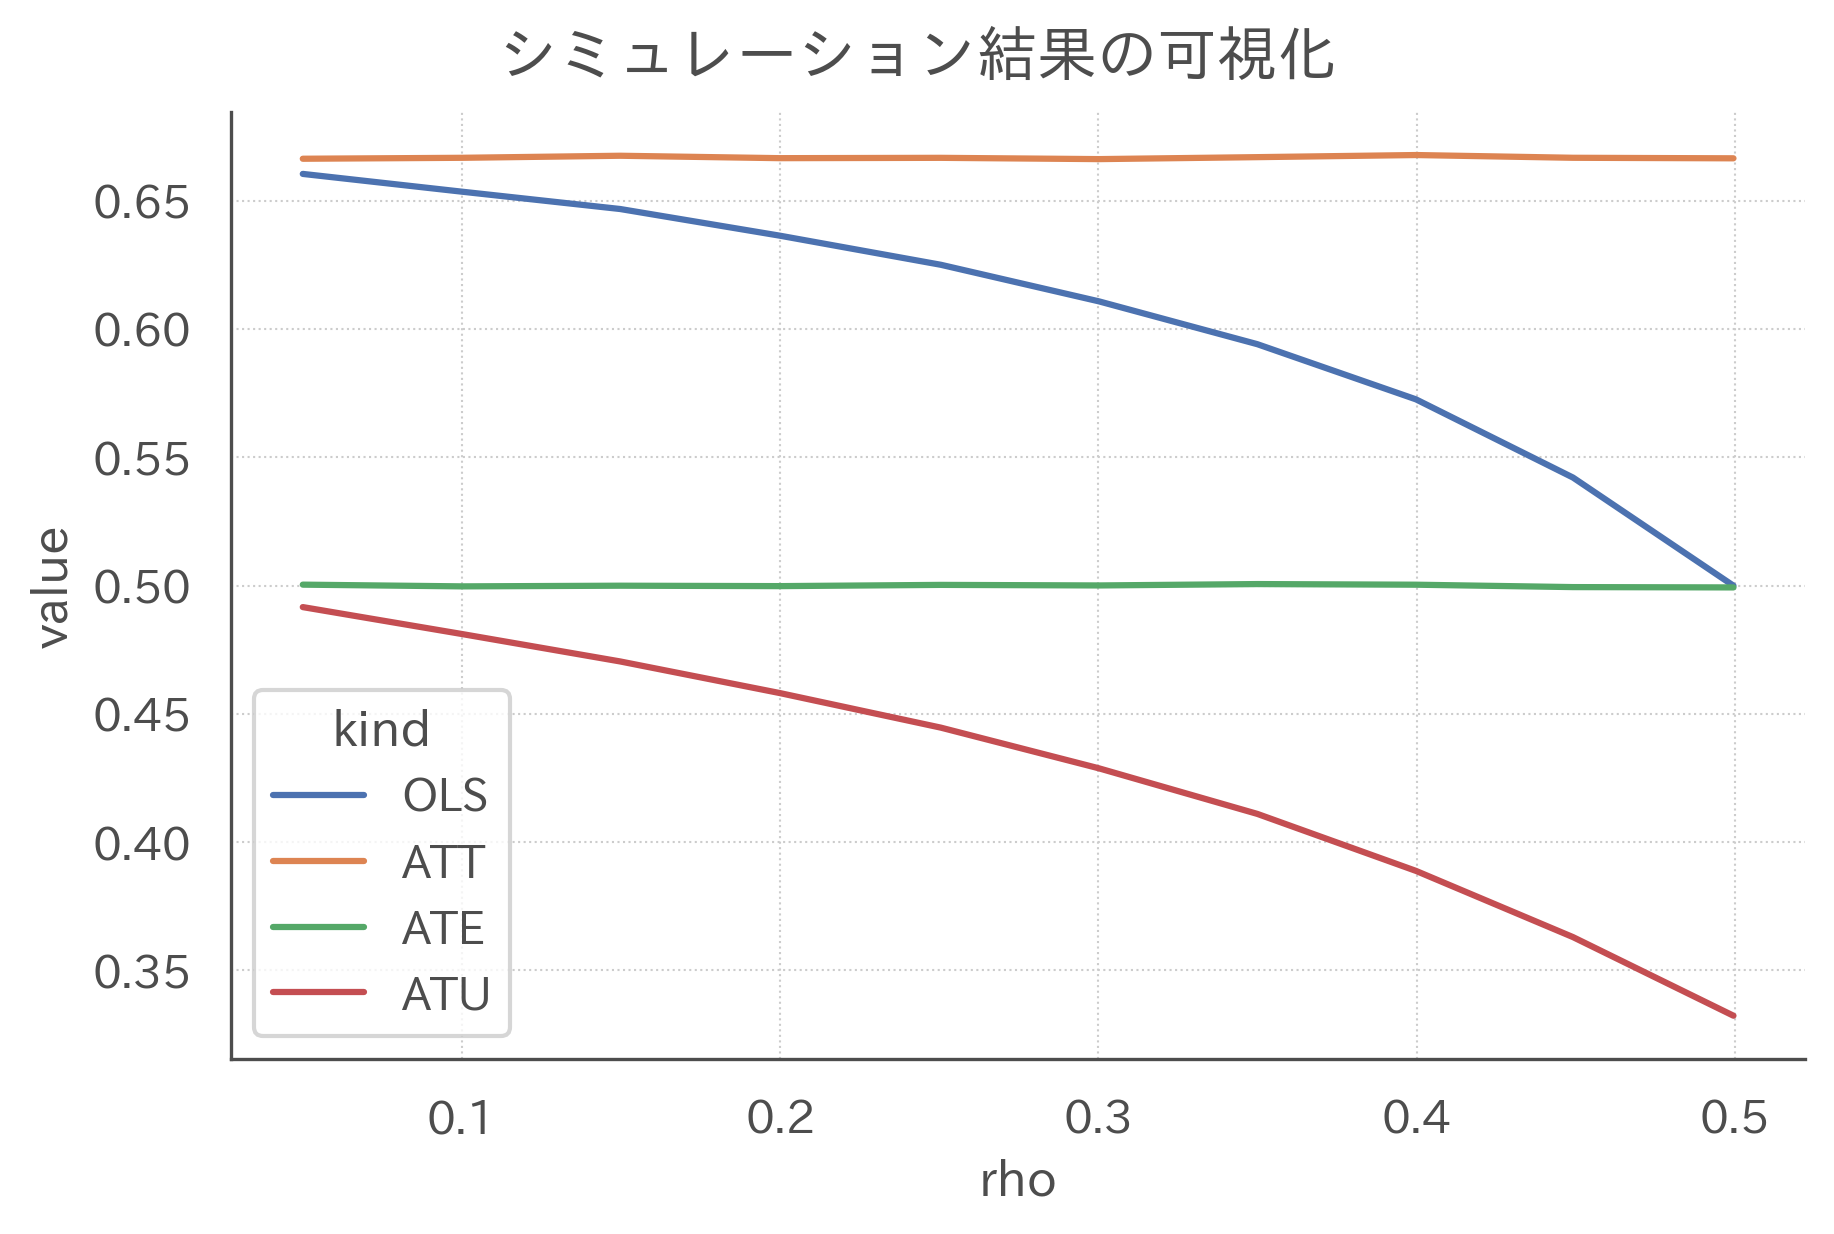

In [5]:
def draw_line(df: pd.Dataframe, title: str) -> None:
    """シミュレーション結果を可視化"""

    df_to_draw = df.melt(
        id_vars=["theta", "rho", "w"],
        value_vars=["OLS", "ATT", "ATE", "ATU"],
        var_name="kind",
    )

    fig, ax = plt.subplots()
    sns.lineplot("rho", "value", hue="kind", data=df_to_draw, ax=ax)
    fig.suptitle(title)
    fig.savefig(f"output/{title}")
    fig.show()


# 可視化
draw_line(df_simulation, "シミュレーション結果の可視化")

まず、処置効果は$\tau(X) = X$で、$X$は区間$[0, 1]$の一様分布に従うので、ATEは処置群の割合$\rho$によらず常に0.5です。
ATTも処置群に割合によらず$0.66$で固定されているようにみえます。
これはATEほど明らかでないので、後ほど理論的な値を確認します。
また、ATUは処置群の割合が増えるほど小さくなっていきます。

さて、今回興味があるのはOLSによる処置効果の推定です。
グラフを確認すると、$\theta$が小さく結果として処置群の割合$\rho$が小さいときは、ATTと近い値をとっています。
一方で、処置群の割合$\rho$が大きくなっていくにつれて、OLS推定量はATTから離れてATUに近づいていく様子が見て取れます。
最終的に$\rho = 0.5$のときは、ATTとATUのちょうど中間に値になっています。
これは論文で主張している理論的なふるまいと一致しており、論文の主張をシミュレーションで確かめることができたと言えるでしょう。

## OLS推定量の理論値の確認

シミュレーション結果でATTが一定であるなどの結果になりましたが、正直あんまり直感的でなくて不安なので理論的な数値も確認しておきました。
まず、$X$が区間$[0, 1]$の一様分布に従うことを利用するとATEはすぐに計算できます。
$$
\begin{align}
\tau_{\ate} &= \E{\tau(X)} = \E{X} = \frac{1}{2}
\end{align}
$$

ATTはちょっと面倒ですが、ベイズの定理で変換することで計算できます。
$$
\begin{align}
\tau_{\att} &= \E{\tau(X) \mid D = 1} \\
&= \int \tau(x) p(x \mid D=1) dx\\
&= \int \tau(x)\frac{\P{D = 1 \mid X = x}p(x) }{\P{D=1}}dx
\end{align}
$$

ここで、それぞれのパーツは
$$
\begin{align}
\tau(x) &= x,\\
\P{D = 1 \mid X = x} &= \theta x,\\
p(x) &= 1, \\
\P{D=1} 
&= \E{\P{D = 1 \mid X = x}}, \\
&= \E{\theta X} \\
&= \theta \E{X} \\
&= \frac{1}{2}\theta
\end{align}
$$
なので、これらを元の式に代入するとATTを得ます。
$$
\begin{align}
\tau_{\att} 
&= \int_0^1 x\frac{\theta x }{\theta / 2}dx\\
&= 2\int_0^1 x^2dx\\
&= \frac{2}{3}
\end{align}
$$

同様にATUも計算します。対照群に対する処置効果を計算するので、
$$
\begin{align}
\P{D = 0 \mid X = x} &= 1 - \theta x\\
\P{D=1} &= 1 - \frac{1}{2}\theta
\end{align}
$$
に注意しながらATTと同様にベイズの定理を用いると
$$
\begin{align}
\tau_{\atu} &= \E{\tau(X) \mid D = 0} \\
&= \int \tau(x) p(x \mid D=1) dx\\
&= \int \tau(x)\frac{\P{D = 0 \mid X = x}p(x) }{\P{D=0}}dx\\
& = \int_0^1 x\frac{1 - \theta x }{1 - \theta / 2}dx\\
&= \frac{2- 3\theta}{3(2 - \theta)}
\end{align}
$$
となります。

最後に重み$w$つまり
$$
\begin{align}
w &= \frac{\paren{1 - \rho}\var{e(X) \mid D=0}}{\rho\var{e(X) \mid D=1} + \paren{1 - \rho}\var{e(X) \mid D=0}}
\end{align}
$$
を計算します。

ひとつひとつのパーツをバラバラに計算して、最後にまとめます。
まずは$D=1$で条件づけた傾向スコアの条件付き分散は
$$
\begin{align}
\var{e(X) \mid D = 1}
&=\E{e(X)^2 \mid D = 1} - \E{e(X) \mid D = 1}^2
\end{align}
$$
なので、
$$
\begin{align}
\E{e(X) \mid D = 1} &= \int e(x)p(x \mid D = 1) = 2\theta\int_0^1 x^2 dx = \frac{2}{3}\theta,\\
\E{e(X)^2 \mid D = 1} &= \int e(x)^2p(x \mid D = 1) = 2\theta^2\int_0^1 x^3 dx = \frac{1}{2}\theta^2
\end{align}
$$
であることを利用すると
$$
\begin{align}
\var{e(X) \mid D = 1}
&= \paren{\frac{1}{2}\theta^2} - \paren{\frac{2}{3}\theta}^2\\
&= \frac{1}{18}\theta^2
\end{align}
$$
となることがわかります。

同様にして、$D=0$で条件づけた傾向スコアの条件付き分散は
$$
\begin{align}
\var{e(X) \mid D = 0}
&=\E{e(X)^2 \mid D = 0} - \E{e(X) \mid D = 0}^2
\end{align}
$$
なので、
$$
\begin{align}
\E{e(X) \mid D = 0} &= \int e(x)p(x \mid D = 0) = \frac{2\theta}{2 - \theta}\int_0^1 \paren{x - \theta x^2} dx = \frac{\theta(3 - 2\theta)}{3(2 - \theta)},\\
\E{e(X)^2 \mid D = 0} &= \int e(x)^2p(x \mid D = 0) = \frac{2\theta^2}{2 - \theta}\int_0^1  \paren{x^2 - \theta x^3} dx = \frac{\theta^2(4 - 3\theta)}{6(2-\theta)}
\end{align}
$$
であることを考慮すると
$$
\begin{align}
\var{e(X) \mid D = 0}
&= \paren{\frac{\theta^2(4 - 3\theta)}{6(2-\theta)}} - \paren{\frac{\theta(3 - 2\theta)}{3(2 - \theta)}}^2\\
&= \frac{\theta^2\paren{\theta^2 - 6\theta + 6}}{18 \paren{2 - \theta}^2}
\end{align}
$$
となります。
ここから重み$w$を計算することができます。

理論値の計算方法がわかったので、これらの理論値を計算する関数を用意して、可視化します。

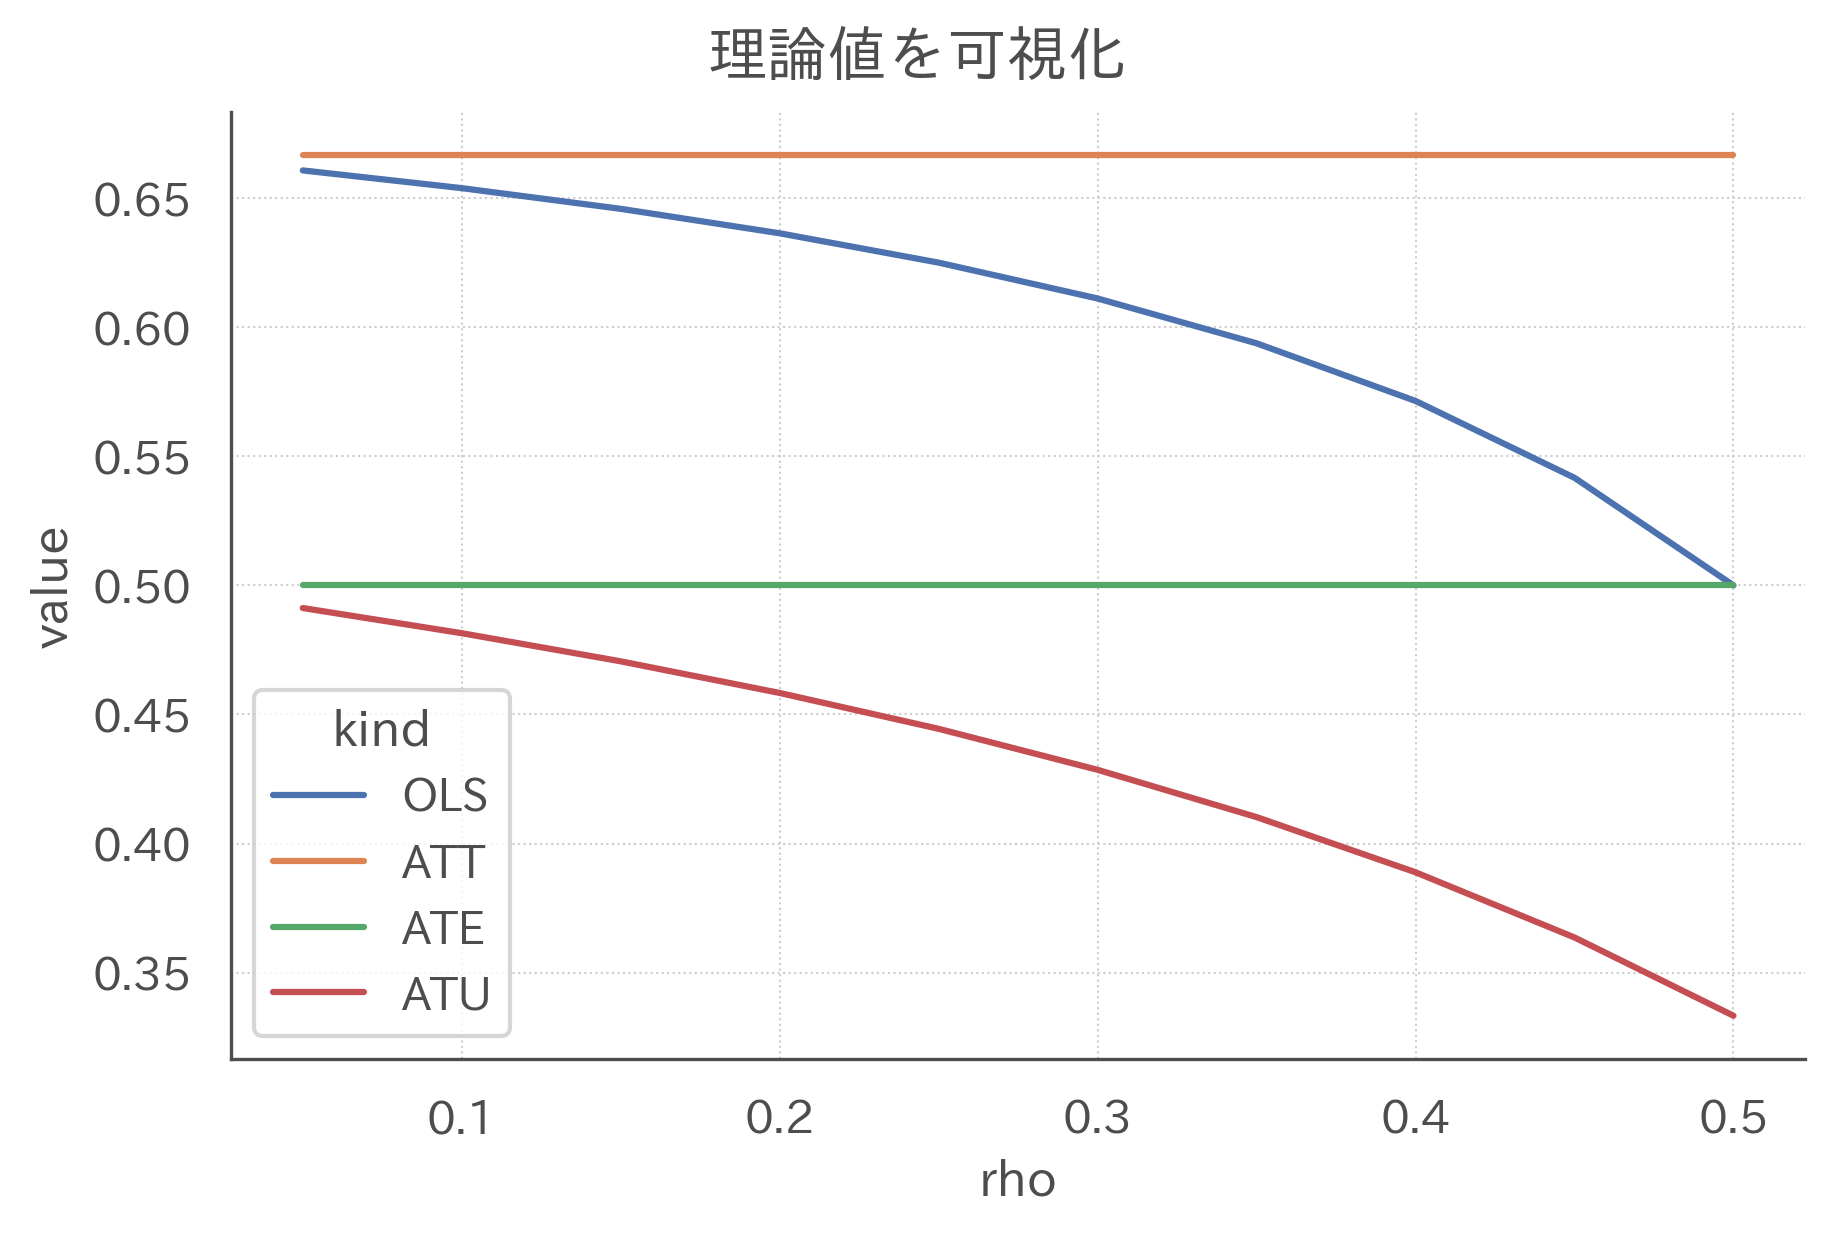

In [6]:
def calc_theoretical_value(theta: np.ndarray) -> pd.DataFrame:

    ate = 0.5
    att = 2 / 3
    atu = (3 - 2 * theta) / (3 * (2 - theta))
    rho = 0.5 * theta

    var_e_0 = theta ** 2 * (theta ** 2 - 6 * theta + 6) / 18 / (2 - theta) ** 2
    var_e_1 = theta ** 2 / 18
    w = (1 - rho) * var_e_0 / ((1 - rho) * var_e_0 + rho * var_e_1)
    ols = w * att + (1 - w) * atu

    df = pd.DataFrame(
        {
            "theta": theta,
            "rho": rho,
            "w": w,
            "OLS": ols,
            "ATT": att,
            "ATU": atu,
            "ATE": ate,
        }
    )
    return df


# 理論値を計算
df_theory = calc_theoretical_value(theta=np.arange(0.1, 1.05, 0.1))

# 可視化
draw_line(df_theory, "理論値を可視化")

理論値はシミュレーション結果と整合的であることが見て取れます。
よかった！

## まとめ

この記事では、Słoczyński(2020)の主張を紹介し、実際にその主張が成り立っているのかをシミュレーションで確認しました。
処置効果に異質性がある場合、OLS推定量はサンプルに占める処置群の割合が大きくなるほどATUに近くなり、対照群の割合が大きくなるほどATTに近くなることがわかりました。

線形回帰モデルが一体何を推定しているかを因果推論の文脈で改めて考える取り組みはすごく面白いトピックだと思っていて、まだまだ勉強していきたいです。

## 参考文献
- Słoczyński, Tymon. "Interpreting ols estimands when treatment effects are heterogeneous: Smaller groups get larger weights." The Review of Economics and Statistics (2020): 1-27.